# Import Libraries & Load Data

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Load Data

In [2]:
# load all data frames

# orders.csv
url = "https://drive.google.com/file/d/1Vu0q91qZw6lqhIqbjoXYvYAQTmVHh6uZ/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
orders = pd.read_csv(path)

# orderlines.csv
url = "https://drive.google.com/file/d/1FYhN_2AzTBFuWcfHaRuKcuCE6CWXsWtG/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
orderlines = pd.read_csv(path)

# products.csv
url = "https://drive.google.com/file/d/1afxwDXfl-7cQ_qLwyDitfcCx3u7WMvkU/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
products = pd.read_csv(path)

# brands.csv
url = "https://drive.google.com/file/d/1OfzJmVsPz9feKXQT_dxFU4FM6hsi2P-7/view?usp=sharing" 
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
brands = pd.read_csv(path)


### Copy DataFrames before making any changes

In [3]:
# copy dataframes

orders_df = orders.copy()
orderlines_df = orderlines.copy()
products_df = products.copy()
brands_df = brands.copy()

In [4]:
# define display format
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_rows', 1000)

# Data-Cleaning

## 1. check `.info()` & `.duplicated()`

In [5]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226909 entries, 0 to 226908
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   order_id      226909 non-null  int64  
 1   created_date  226909 non-null  object 
 2   total_paid    226904 non-null  float64
 3   state         226909 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 6.9+ MB


- `total_paid` - 5 missing values
- `created_date` - needs to be datetime datatype

In [6]:
orderlines_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293983 entries, 0 to 293982
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                293983 non-null  int64 
 1   id_order          293983 non-null  int64 
 2   product_id        293983 non-null  int64 
 3   product_quantity  293983 non-null  int64 
 4   sku               293983 non-null  object
 5   unit_price        293983 non-null  object
 6   date              293983 non-null  object
dtypes: int64(4), object(3)
memory usage: 15.7+ MB


- `date` - needs to be datetime datatype
- `unit_price` - needs to be a float datatype

In [7]:
products_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19326 entries, 0 to 19325
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   sku          19326 non-null  object
 1   name         19326 non-null  object
 2   desc         19319 non-null  object
 3   price        19280 non-null  object
 4   promo_price  19326 non-null  object
 5   in_stock     19326 non-null  int64 
 6   type         19276 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.0+ MB


- missing values in `desc` & `price`
- wrong datatype for `price` & `promo_price`

In [8]:
# orders
orders_df.duplicated().sum()

np.int64(0)

In [9]:
# orderlines
orderlines_df.duplicated().sum()

np.int64(0)

no duplicates in either DataFrame

In [10]:
# products
products_df.duplicated().sum()

np.int64(8746)

- significant amount of duplicates, need to be dropped

In [11]:
products_df = products_df.drop_duplicates()

## 2. Missing values

### 2.1. Orders
- `total_paid` with 5 missing values

In [12]:
# amount of missing values of all data
orders_df.total_paid.isna().value_counts(normalize=True)

total_paid
False   1.00
True    0.00
Name: proportion, dtype: float64

- since only small amount, it can be simple removed

In [13]:
orders_df = orders_df.loc[~orders.total_paid.isna(), :]

### 2.2. Orderlines 
- no missing values in `orderlines`

### 2.3 Products
- only 7 missing values in `desc` - will be replaced with input from `name`
- missing values in `price`will be dropped, as clear data in this column is important for further analysis

In [14]:
# replace missing values in desc with name
products_df.loc[products_df['desc'].isna(), 'desc'] = products_df.loc[products_df['desc'].isna(), 'name']

In [15]:
# see how many prices are missing
products_df["price"].isna().value_counts(normalize=True)

price
False   1.00
True    0.00
Name: proportion, dtype: float64

In [16]:
#  drop missing values in price
products_df = products_df.dropna(subset=['price'])

## 3. Change Datatypes

### 3.1. Orders
- `created date` should be datetime datatype

In [17]:
orders_df["created_date"] = pd.to_datetime(orders_df["created_date"])

### 3.2. Orderlines
- `date` should be datetimes datatype
- `unitprice` should be float datatype

In [18]:
# date to datetime datatype
orderlines_df["date"] = pd.to_datetime(orderlines_df["date"])

- convert datatype for `unit_price`

In [19]:
# detect numbers with more than one decimal point
orderlines_df['unit_price'].str.count(r'\.').value_counts(normalize=True)

unit_price
1   0.88
2   0.12
Name: proportion, dtype: float64

- with 12.3%, a significant amount of data corrupted 
- due to time-contraint on the data will be dropped

In [20]:
# find orders that have orderlines with corrupted data in 'unit_price'
two_dot_order_ids_list = orderlines_df.loc[orderlines_df.unit_price.str.contains("\d+\.\d+\.\d+"), "id_order"]

# remove those lines in orderlines dataframe
orderlines_df = orderlines_df.loc[~orderlines_df.id_order.isin(two_dot_order_ids_list)]


<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
C:\Users\anna_\AppData\Local\Temp\ipykernel_24044\2527953061.py:2: SyntaxWarning: invalid escape sequence '\d'
  two_dot_order_ids_list = orderlines_df.loc[orderlines_df.unit_price.str.contains("\d+\.\d+\.\d+"), "id_order"]


In [21]:
orderlines_df.shape[0]

216250

- still 216250 rows left in orderlines to use for analysis

In [22]:
# convert now unit_price to numeric (float)
orderlines_df["unit_price"] = pd.to_numeric(orderlines_df["unit_price"])

### 3.3 Products
- convert datatype for `price`

In [23]:
# check data for amount of decimal-dots 
products['price'].str.count(r'\.').value_counts(normalize=True)

price
0.00   0.60
1.00   0.38
2.00   0.02
Name: proportion, dtype: float64

In [24]:
price_problems_number = products_df.loc[(products_df["price"].astype(str).str.contains(r"\d+\.\d+\.\d+"))|(products_df["price"].astype(str).str.contains(r"\d+\.\d{3,}")), :].shape[0]
price_problems_number

print(f"{round(((price_problems_number / products_df.shape[0]) * 100), 2)}% of the rows of the DataFrame are effected by the decimal-dot problem")

5.15% of the rows of the DataFrame are effected by the decimal-dot problem


- 5.15% is a significant amount, but column is important for analysis, so corrupted rows will be dropped

In [25]:
# drop corrupted lines
products_df = products_df.loc[(~products_df["price"].astype(str).str.contains(r"\d+\.\d+\.\d+"))&(~products_df["price"].astype(str).str.contains(r"\d+\.\d{3,}")), :]


In [26]:
# convert price to numeric (float)
products_df["price"] = pd.to_numeric(products_df["price"])

- check `promo_price`

In [27]:
# check data for amount of decimal-dots 
products['promo_price'].str.count(r'\.').value_counts(normalize=True)

promo_price
2   0.67
1   0.32
0   0.01
Name: proportion, dtype: float64

- due to high amount of corrupted data (66%), column will be dropped
- promo price can be later calculated with price out of orders together with price column in product DataFrame

In [28]:
# drop promo_price
products_cl = products_df.drop(columns=["promo_price"])

## 4. Save cleaned DataFrames to CSV

In [29]:
#rename DataFrames
orders_cl = orders_df.copy()
orderlines_cl = orderlines_df.copy() 

In [30]:
#orders
orders_cl.to_csv("orders_cl.csv", index=False)

# orderlines
orderlines_cl.to_csv("orderlines_cl.csv", index=False)

# products
products_cl.to_csv("products_cl.csv", index=False)


# Data-Quality

## 1. Exclude unwanted orders

In [31]:
# Filter to completed orders
state_mask = orders_cl['state'] == 'Completed'
# Apply filter
orders_completed = orders_cl.loc[state_mask].copy()

In [32]:
# Filter orderlines to only those in completed orders

# Get order ids of completed orders
completed_order_ids = orders_completed['order_id']

# Filter orderlines to just those completed orders
orderlines_state_mask = orderlines_cl['id_order'].isin(completed_order_ids)

# Apply filter
orderlines_completed = orderlines_cl.loc[orderlines_state_mask].copy()

In [33]:
# Looking for orderlines with no orders
set(orderlines_completed['id_order']) - set(orders_completed['order_id'])

set()

In [34]:
# Looking for orders with no orderlines
set(orders_completed['order_id'])  - set(orderlines_completed['id_order'])

{393219,
 521032,
 516103,
 319497,
 352267,
 475148,
 499725,
 434192,
 466962,
 401427,
 352276,
 368661,
 426006,
 434199,
 507922,
 344089,
 417821,
 376861,
 516129,
 426018,
 442402,
 475171,
 466992,
 475184,
 466998,
 467000,
 360505,
 385080,
 499774,
 516160,
 434242,
 426051,
 475202,
 376901,
 319558,
 360519,
 475208,
 303185,
 467026,
 442451,
 360532,
 499794,
 393309,
 360544,
 409699,
 360551,
 434281,
 303210,
 360553,
 499818,
 434287,
 499827,
 499828,
 319606,
 401528,
 360569,
 483458,
 401545,
 409737,
 467085,
 409742,
 475278,
 426128,
 475279,
 393362,
 360594,
 508052,
 393365,
 311445,
 352408,
 467099,
 516252,
 401565,
 393374,
 368799,
 467114,
 344234,
 467116,
 344242,
 360627,
 245941,
 426167,
 311482,
 311492,
 483526,
 377035,
 360661,
 303319,
 344285,
 483549,
 311522,
 483557,
 467174,
 458986,
 418033,
 483570,
 483574,
 467194,
 516348,
 467198,
 311553,
 401668,
 426249,
 467211,
 483595,
 344333,
 352529,
 491794,
 434451,
 483607,
 393496,
 

In [35]:
# Removing orders that have no orderlines

# Get collection of orders that are in the orderlines table
existing_orderlines = orderlines_completed['id_order'].copy()

# Filter to just orders in orderlines table
overlap_mask = orders_completed['order_id'].isin(existing_orderlines)

# Apply filter
orders_coherent = orders_completed.loc[overlap_mask].copy()

## 2. Exclude orders with unknown products

In [36]:
# Remove all orders and orderlines if any orderline's product is missing

# 1. Identify corrupted orderlines (missing their products)
# (Note: This could be done more concisely)

# Identify products we actually have information about
existing_products = products_cl['sku']
# Create new column to track the status of the orderline
orderlines_completed.loc[:, 'Corrupted'] = False
# Identify orderlines with existing products
products_there_mask = orderlines_completed['sku'].isin(existing_products)
# Label all orderlines with *missing* products corrupted
orderlines_completed.loc[~products_there_mask, 'Corrupted'] = True


# 2. Identify corrupted orders (with corrupted orderlines)

# Filter to corrupted orderlines
corrupted_mask = orderlines_completed['Corrupted']==True
# Identify which orders they are in
corrupted_orders = orderlines_completed.loc[corrupted_mask, 'id_order']


# 3. Filter our by corrupted orders

# Creating filters to remove corrupted orders from both data frame
corrupted_orders_mask = orders_coherent['order_id'].isin(corrupted_orders)
corrupted_orderlines_mask = orderlines_completed['id_order'].isin(corrupted_orders)
# Applying filters
orders_qu = orders_coherent.loc[~corrupted_orders_mask]
orderlines_qu = orderlines_completed.loc[~corrupted_orderlines_mask]

## 3. save DataFrames after Quality Assessment to csv

In [36]:
#orders
orders_qu.to_csv("orders_qu.csv", index=False)

# orderlines
orderlines_qu.to_csv("orderlines_qu.csv", index=False)

# Analysis

## 1. Final DataFrame 

### 1.1. Categorize Products (approx 85% of all products)

In [46]:
# Categories DataFrame
category_df = products_cl.copy()

In [49]:
# Categorize by 'name'
conditions = [
    category_df['name'].str.contains('iPhone|AppleCare|Pencil|Protector', case=False, na=False),
    category_df['name'].str.contains('AirPods|Headset|EarPods|Headphones|Audio', case=False, na=False),
    category_df['name'].str.contains('SSD|Hard Drive|Memory|RAM|Thunderbolt|Adapter|Cable|Mouse|Keyboard|Monitor|Tool|Battery|Temperature Sensor', case=False, na=False),
    category_df['name'].str.contains('Charger|Battery|Power|Hub|USB|Lamp', case=False, na=False),
    category_df['name'].str.contains('Tablet|iPad|Wacom|Graphics Tablet|Keyboard Folio', case=False, na=False),
    category_df['name'].str.contains('Drive|Storage|External|Sandisk|LaCie|WD|USB drive|Lightning', case=False, na=False),
    category_df['name'].str.contains('Monitor|Display|Screen|QHD|IPS', case=False, na=False),
    category_df['name'].str.contains('Lamp|Thermostat|Gadget|Tools|Repair Kit|Valve|Radiator|Smart|Home', case=False, na=False),
    category_df['name'].str.contains('Apple Watch|Wearable|Smartwatch', case=False, na=False),
    category_df['name'].str.contains('Speaker|Bluetooth Speaker|Audio|Sonos|JBL', case=False, na=False),
    category_df['name'].str.contains('Backpack|MacBook Case|Bag|Cover|Pleated|Crossover', case=False, na=False),  # Expanded keywords for Computer Bags & Cases
    category_df['name'].str.contains('Robot|Toy|Smartoy|Sphero|Droid', case=False, na=False),
    category_df['name'].str.contains('Trackr|Locator|Bluetooth Locator', case=False, na=False),
    category_df['name'].str.contains('Tempered Glass|Screen Protector', case=False, na=False),
    category_df['name'].str.contains('Repair Kit|iFixit|Rubber Kit', case=False, na=False),
    category_df['name'].str.contains('Hard Disk|HDD|SSHD|Storage|Seagate', case=False, na=False)
]

# Define categories corresponding to each condition
categories = [
    'Smartphones & Accessories',
    'Audio & Headphones',
    'Computer Components & Peripherals',
    'Power & Charging',
    'Tablets & Accessories',
    'Storage & External Drives',
    'Displays & Monitors',
    'Other Electronics & Gadgets',
    'Wearable Technology',
    'Audio & Speakers',
    'Computer Bags & Cases',  # Computer Bags & Cases category
    'Toys & Gadgets',
    'Home Automation & Smart Devices',
    'Screen Protectors',
    'Repair Tools & Accessories',
    'Storage Devices'
]

# Apply conditions to create a new 'category' column based on product type
category_df['category'] = np.select(conditions, categories, default='Uncategorized')

# Display the updated DataFrame
category_df

,sku,name,desc,price,in_stock,type,category
0,RAI0007,Silver Rain Design mStand Support,Aluminum support compatible with all MacBook,59.99,1,8696,Uncategorized
1,APP0023,Apple Mac Keyboard Keypad Spanish,USB ultrathin keyboard Apple Mac Spanish.,59.00,0,13855401,Computer Components & Peripherals
2,APP0025,Mighty Mouse Apple Mouse for Mac,mouse Apple USB cable.,59.00,0,1387,Computer Components & Peripherals
3,APP0072,Apple Dock to USB Cable iPhone and iPod white,IPhone dock and USB Cable Apple iPod.,25.00,0,1230,Smartphones & Accessories
4,KIN0007,Mac Memory Kingston 2GB 667MHz DDR2 SO-DIMM,2GB RAM Mac mini and iMac (2006/07) MacBook Pr...,34.99,1,1364,Computer Components & Peripherals
...,...,...,...,...,...,...,...
19321,BEL0376,Belkin Travel Support Apple Watch Black,compact and portable stand vertically or horiz...,29.99,1,12282,Wearable Technology
19322,THU0060,"Enroute Thule 14L Backpack MacBook 13 ""Black",Backpack with capacity of 14 liter compartment...,69.95,1,1392,Computer Bags & Cases
19323,THU0061,"Enroute Thule 14L Backpack MacBook 13 ""Blue",Backpack with capacity of 14 liter compartment...,69.95,1,1392,Computer Bags & Cases
19324,THU0062,"Enroute Thule 14L Backpack MacBook 13 ""Red",Backpack with capacity of 14 liter compartment...,69.95,0,1392,Computer Bags & Cases


In [50]:
category_df['category'].value_counts(normalize=True)

category
Computer Components & Peripherals   0.37
Smartphones & Accessories           0.20
Uncategorized                       0.14
Tablets & Accessories               0.08
Power & Charging                    0.05
Storage & External Drives           0.03
Wearable Technology                 0.03
Audio & Headphones                  0.02
Storage Devices                     0.02
Audio & Speakers                    0.02
Other Electronics & Gadgets         0.01
Computer Bags & Cases               0.01
Displays & Monitors                 0.01
Toys & Gadgets                      0.00
Home Automation & Smart Devices     0.00
Repair Tools & Accessories          0.00
Screen Protectors                   0.00
Name: proportion, dtype: float64

### 1.2. Merge Orderlines, Categories & Brands

In [65]:
# Merge all tables & clean up for better usability

orderlines_final_df = orderlines_qu.merge(category_df,
                                          how = 'left',
                                          on = 'sku').copy()
orderlines_final_df['short'] = orderlines_final_df['sku'].str[:3]
orderlines_final_df = orderlines_final_df.merge(brands,
                                                how = 'left',
                                                on = 'short').copy()
orderlines_final_df = orderlines_final_df.drop(columns = ['Corrupted','in_stock','type','short'])
orderlines_final_df = orderlines_final_df.rename(columns= {'id_order':'order_id','unit_price':'price_sold','price':'price_og','long':'brand'})
orderlines_final_df

,id,order_id,product_id,product_quantity,sku,price_sold,date,name,desc,price_og,category,brand
0,1119116,299545,0,1,OWC0100,47.49,2017-01-01 01:46:16,OWC In-line Digital Temperature Sensor Kit HDD...,Kit temperature sensor for HDD iMac 21 inch an...,60.99,Computer Components & Peripherals,OWC
1,1119119,299546,0,1,IOT0014,18.99,2017-01-01 01:50:34,iOttie Easy View 2 Car Black Support,IPhone car holder 7 plus / 7/6 Plus / 6 / 5s /...,22.95,Uncategorized,iOttie
2,1119120,295347,0,1,APP0700,72.19,2017-01-01 01:54:11,Apple 85W MagSafe 2 charger MacBook Pro screen...,Apple MagSafe 2 Charger for MacBook Pro 15-inc...,89.00,Power & Charging,Apple
3,1119134,299556,0,1,CRU0039-A,60.90,2017-01-01 02:20:14,(Open) Crucial 240GB SSD 7mm BX200,SSD hard drive and high-speed performance with...,76.99,Computer Components & Peripherals,Crucial
4,1119145,299561,0,1,PEB0015,142.49,2017-01-01 02:38:50,Pebble Smartwatch Time Steel Black,Bluetooth Smart Watch with steel case leather ...,299.99,Other Electronics & Gadgets,Pebble
...,...,...,...,...,...,...,...,...,...,...,...,...
54319,1649474,525664,0,1,TUC0207,16.52,2018-03-14 11:45:05,Tucano Elements Second Skin Macbook Sleeve 12 ...,velvety inner protective case for MacBook 12 i...,24.99,Uncategorized,Tucano
54320,1649512,527070,0,2,APP0698,9.99,2018-03-14 11:49:01,Apple Lightning Cable Connector to USB 1m Whit...,Apple Lightning USB Cable 1 meter to charge an...,25.00,Computer Components & Peripherals,Apple
54321,1649522,527074,0,2,APP0698,9.99,2018-03-14 11:49:36,Apple Lightning Cable Connector to USB 1m Whit...,Apple Lightning USB Cable 1 meter to charge an...,25.00,Computer Components & Peripherals,Apple
54322,1649565,527096,0,3,APP0698,9.99,2018-03-14 11:54:35,Apple Lightning Cable Connector to USB 1m Whit...,Apple Lightning USB Cable 1 meter to charge an...,25.00,Computer Components & Peripherals,Apple


### 1.3. Calculate Discount, Total Revenue p. Line & add Seasonality

In [ ]:
# Calculate Discount
discount_calc = orderlines_final_df['price_og']-orderlines_final_df['price_sold']
orderlines_final_df['discount'] = discount_calc


In [67]:
# Calculate Discount in %
discount_percentage = orderlines_final_df['discount']/orderlines_final_df['price_og']*100
orderlines_final_df['discount_percentage'] = discount_percentage

In [68]:
# Calculate Total Revenue per Line
total_rev = orderlines_final_df['product_quantity']*orderlines_final_df['price_sold']
orderlines_final_df['total_revenue'] = total_rev

In [ ]:
# Seasonality
orderlines_final_df['date'] = pd.to_datetime(orderlines_final_df['date'])
orderlines_final_df.insert(2, "year", orderlines_final_df["date"].dt.year)
orderlines_final_df.insert(3, "month", orderlines_final_df["date"].dt.month)

In [72]:
# Function for Seasonality Label
def label_season(row):
    if row['month'] == 11:
        return 'Black Friday'
    if row['month'] == 1:
        return 'Wintersale'
    if row['month'] ==7:
        return 'Summersale'
    else:
        return 'No Sale Season'
    
# Apply Function
orderlines_final_df['seasonality'] = orderlines_final_df.apply(label_season, axis=1)
orderlines_final_df.sample(10)

,id,order_id,year,month,product_id,product_quantity,sku,price_sold,date,name,desc,price_og,category,brand,discount,discount_percentage,total_revenue,seasonality
6472,1171141,319857,2017,2,0,1,ZAG0022,10.99,2017-02-04 12:49:04,Zagg invisibleSHIELD Screen Protector Apple Wa...,Screen Protector for Apple Watch.,16.99,Smartphones & Accessories,ZaggKeys,6.00,35.31,10.99,No Sale Season
33915,1445977,443025,2017,11,0,1,SNS0019,164.68,2017-11-25 11:55:37,Sonos Play 1 Bluetooth Speaker Black,Wireless Speaker for iPhone iPad and iPod.,179.00,Audio & Speakers,Sonos,14.32,8.00,164.68,Black Friday
29255,1405342,425779,2017,11,0,1,DLL0054,630.49,2017-11-12 13:01:22,"Dell UltraSharp U2718Q Monitor 27 ""4K",Productivity gains and image quality 4K monito...,758.99,Computer Components & Peripherals,Dell,128.50,16.93,630.49,Black Friday
30034,1414401,428864,2017,11,0,1,IFX0035,24.99,2017-11-20 06:29:30,Full iFixit Battery Kit iPhone 5C battery change,Battery replacement kit with tools for iPhone 5C.,24.95,Smartphones & Accessories,iFixit,-0.04,-0.16,24.99,Black Friday
4401,1156177,313645,2017,1,0,1,CRU0032,59.99,2017-01-23 10:34:35,Crucial Mac Memory 8GB DDR3 1333MHz SO-DIMM,8GB RAM Mac mini iMac (2010/11) and MacBook Pr...,81.99,Computer Components & Peripherals,Crucial,22.00,26.83,59.99,Wintersale
7733,1181042,324342,2017,2,0,1,SEA0044,89.29,2017-02-14 23:55:24,"Seagate Barracuda 3TB 35 ""SATA hard drive Mac ...",internal hard drive Mac and PC 3TB (ST3000DM008).,112.00,Computer Components & Peripherals,Seagate,22.71,20.28,89.29,No Sale Season
25660,1377879,412432,2017,10,0,1,SAT0049,29.99,2017-10-14 12:22:09,Satechi Support Aluminum Gray Space Headphones,Support Headphones with aluminum finish and st...,39.99,Audio & Headphones,Satechi,10.00,25.01,29.99,No Sale Season
8767,1207913,336599,2017,3,0,1,SAN0120,25.99,2017-03-18 20:58:27,Sandisk Extreme Pro SDHC UHS-I 32GB U3 V30 95M...,32GB memory card speeds UHS Class 3 95MB / s-9...,29.99,Storage & External Drives,SanDisk,4.00,13.34,25.99,No Sale Season
9498,1229639,346956,2017,4,0,1,LGE0044,569.99,2017-04-18 10:19:53,"LG 27UD88-W Monitor 27 ""UHD 4K USB 3.0 USB-C",99% Professional Monitor sRGB color calibrator...,599.00,Computer Components & Peripherals,LG,29.01,4.84,569.99,No Sale Season
22341,1349461,398561,2017,9,0,1,ALL0011,12.99,2017-09-10 23:22:36,Allocacoc PowerCube Extended plug strip White ...,Outlet power strip extension 15m cube-shaped 5...,14.95,Power & Charging,Allocacoc,1.96,13.11,12.99,No Sale Season


In [73]:
#Save final DataFrame

orderlines_final_df.to_csv("orderlines_final.csv", index=False)

## 2. Visualizations 

### 2.1. Seasonality

In [5]:
# Avg Ordervolume

order_seasonal_quantity = (orderlines_final_df.groupby(['seasonality','month'])
                           .agg({'discount_percentage':'mean','total_revenue':'sum','product_quantity':'sum','order_id':'count'}))
order_seasonal_quantity


discount_percentage  total_revenue  product_quantity  \
seasonality    month                                                         
Black Friday   11               22.229800     1534336.01              9795   
No Sale Season 2                21.450549      869243.79              7322   
               3                21.872571      248507.86              2141   
               4                18.511407      232390.78              2171   
               5                15.557947      338548.71              2613   
               6                17.771197      291986.14              2119   
               8                20.724519      383058.17              3075   
               9                20.404727      400903.79              2841   
               10               22.208662      561774.83              4100   
               12               19.649187     1006182.24              6803   
Summersale     7                25.095924      616851.00              4745   
Wintersale     1                23.518289     1487836.85             13581   

                      order_id  
seasonality    month            
Black Friday   11         8627  
No Sale Season 2          6458  
               3          1878  
               4          1917  
               5          2199  
               6          1793  
               8          2750  
               9          2544  
               10         3660  
               12         6203  
Summersale     7          4233  
Wintersale     1         12062

In [6]:
# Set palette
palette={'Black Friday':'black','No Sale Season':'gainsboro','Summersale':'orange','Wintersale':'navy'}

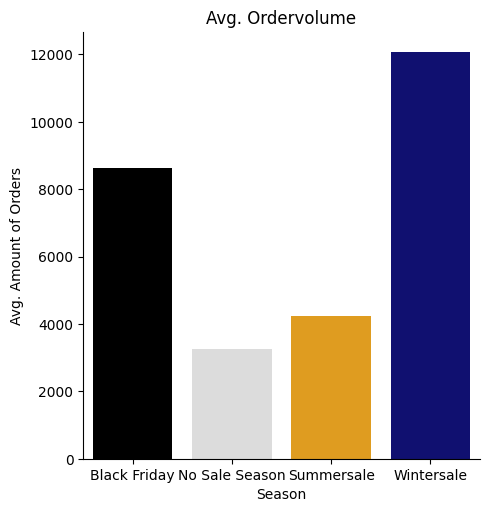

In [7]:
quantity =sns.catplot(kind='bar',
            data=order_seasonal_quantity,
            x='seasonality',
            y= 'order_id',
            estimator='mean',
            hue='seasonality',
            palette=palette,
            errorbar=None);

quantity.set(xlabel='Season',ylabel='Avg. Amount of Orders')
quantity.set(title='Avg. Ordervolume');

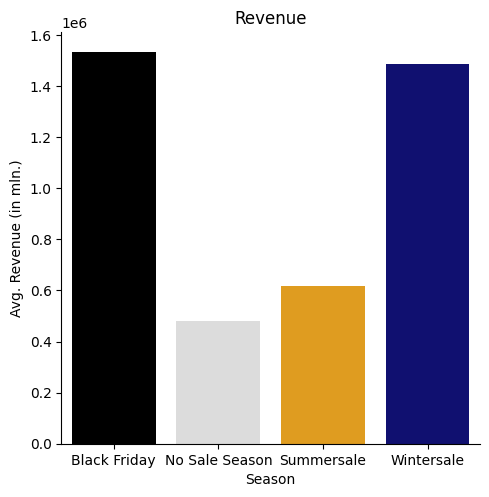

In [10]:
revenue =sns.catplot(kind='bar',
            data=order_seasonal_quantity,
            x='seasonality',
            y= 'total_revenue',
            estimator='mean',
            hue='seasonality',
            palette=palette,
            errorbar=None);
revenue.set(xlabel='Season',ylabel='Avg. Revenue (in mln.)')
revenue.set(title='Revenue');


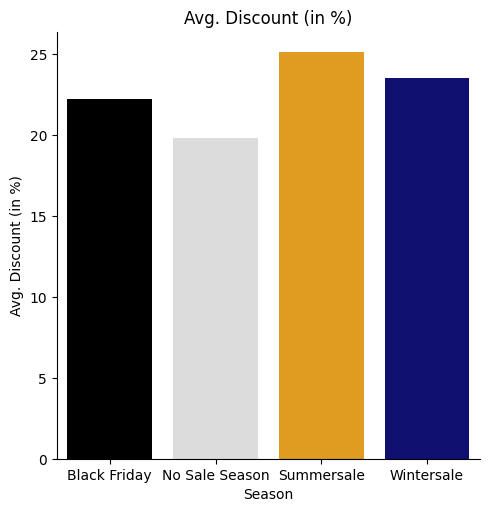

In [12]:
discount =sns.catplot(kind='bar',
            data=order_seasonal_quantity,
            x='seasonality',
            y= 'discount_percentage',
            estimator='mean',
            hue='seasonality',
            palette=palette,
            errorbar=None);

discount.set(xlabel='Season',ylabel='Avg. Discount (in %)')
discount.set(title='Avg. Discount (in %)');

### 2.2. Brands

In [18]:
# Top Brands

top_10_brands_df = (
                    orderlines_final_df.groupby('brand', as_index = False)
                    .agg({'discount_percentage':'mean','product_quantity':'sum', 'total_revenue':'sum'})
                    .nlargest(10,'product_quantity')
)
top_10_brands_df

,brand,discount_percentage,product_quantity,total_revenue
5,Apple,16.701251,11393,2646796.29
99,OWC,22.502010,3946,465107.31
161,Western Digital,18.498978,2442,369856.65
9,Belkin,29.283188,2332,73220.83
67,LaCie,11.808739,2167,462344.02
19,Crucial,13.866972,2103,278664.92
128,Satechi,30.541677,1877,75753.77
160,Wacom,20.045918,1835,279960.23
106,Pack,26.367166,1740,471382.86
91,NewerTech,35.767168,1705,91054.52


C:\Users\anna_\AppData\Local\Temp\ipykernel_16392\4169548510.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='brand', y='product_quantity', data=top_10_brands_df, ax=ax1, palette='viridis')


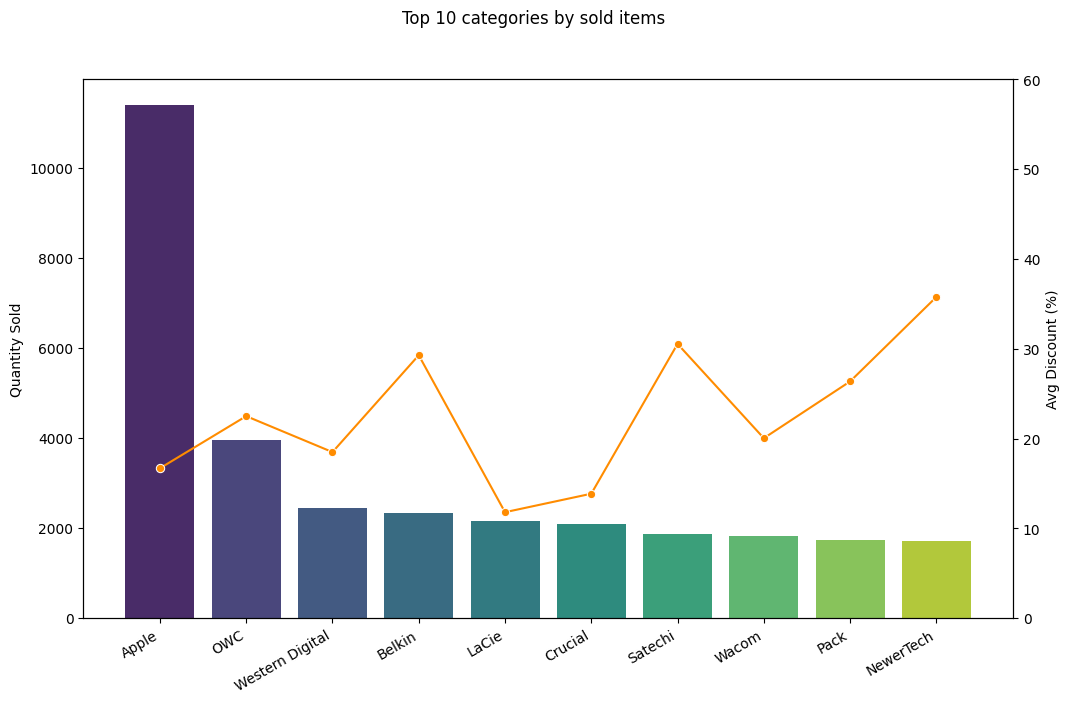

In [16]:
# Creating the figure - top brands by sold items
fig, ax1 = plt.subplots(figsize=(12,7))
sns.barplot(x='brand', y='product_quantity', data=top_10_brands_df, ax=ax1, palette='viridis')
ax1.set_ylabel('Quantity Sold')
ax1.set_xlabel(' ')

ax2 = ax1.twinx()
sns.lineplot(x='brand', y='discount_percentage', data=top_10_brands_df, ax=ax2, color='darkorange', marker ='o')
ax2.set_ylabel('Avg Discount (%)')
ax2.set_ylim(0,60)
fig.suptitle('Top 10 categories by sold items')
for label in ax1.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
plt.show();

C:\Users\anna_\AppData\Local\Temp\ipykernel_16392\2393711924.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='brand', y='total_revenue', data=top_10_revenue, ax=ax1, palette='viridis')


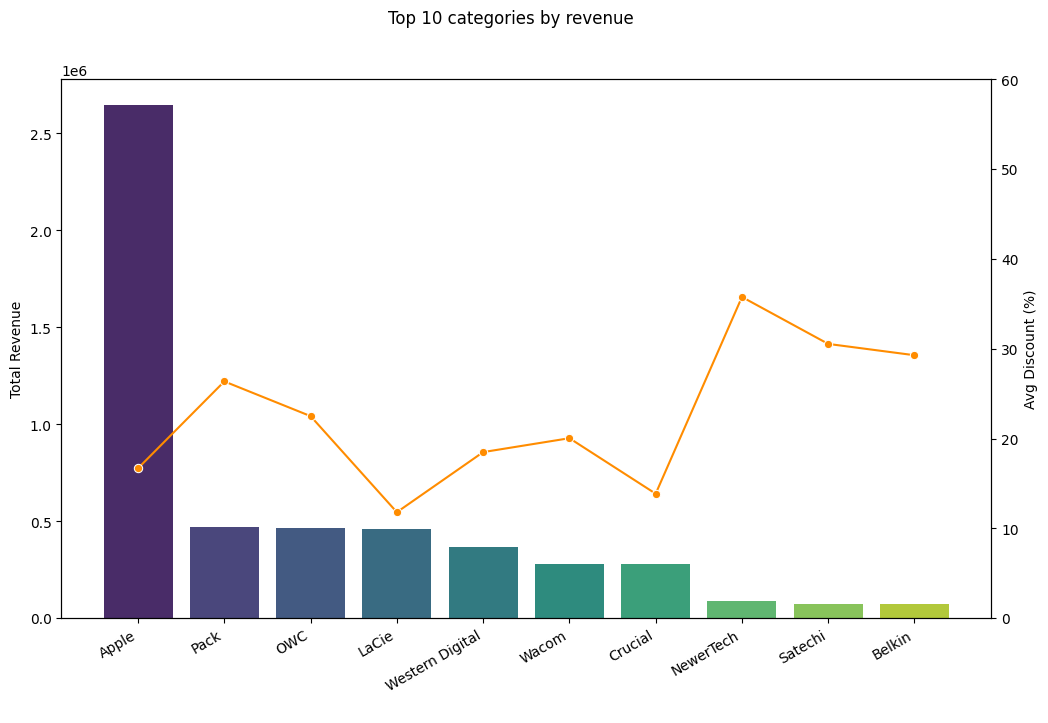

In [23]:
# Creating the figure - top brands by revenue
top_10_revenue = top_10_brands_df.sort_values('total_revenue', ascending=False)

fig, ax1 = plt.subplots(figsize=(12,7))
sns.barplot(x='brand', y='total_revenue', data=top_10_revenue, ax=ax1, palette='viridis')
ax1.set_ylabel('Total Revenue')
ax1.set_xlabel(' ')

ax2 = ax1.twinx()
sns.lineplot(x='brand', y='discount_percentage', data=top_10_revenue, ax=ax2, color='darkorange', marker ='o')
ax2.set_ylabel('Avg Discount (%)')
ax2.set_ylim(0,60)
fig.suptitle('Top 10 categories by revenue')
for label in ax1.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
plt.show();

### 2.3 Categories

In [21]:
# Top Categories

top_10_categories_df = (
                    orderlines_final_df.groupby('category', as_index = False)
                    .agg({'discount_percentage':'mean','product_quantity':'sum', 'total_revenue':'sum'})
                    .nlargest(10,'product_quantity')
)
top_10_categories_df

,category,discount_percentage,product_quantity,total_revenue
3,Computer Components & Peripherals,21.273236,25879,3562987.66
10,Smartphones & Accessories,22.011572,13143,1835523.75
7,Power & Charging,23.347289,5872,345447.10
15,Uncategorized,20.212968,4082,443717.40
13,Tablets & Accessories,20.233869,3357,714369.39
0,Audio & Headphones,32.310374,2276,229434.77
11,Storage & External Drives,14.337540,1225,175462.70
16,Wearable Technology,14.927313,1009,228414.82
4,Displays & Monitors,15.254990,951,75988.42
1,Audio & Speakers,22.079979,881,145152.96


C:\Users\anna_\AppData\Local\Temp\ipykernel_16392\3028116226.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='category', y='product_quantity', data=top_10_categories_df, ax=ax1, palette='viridis')


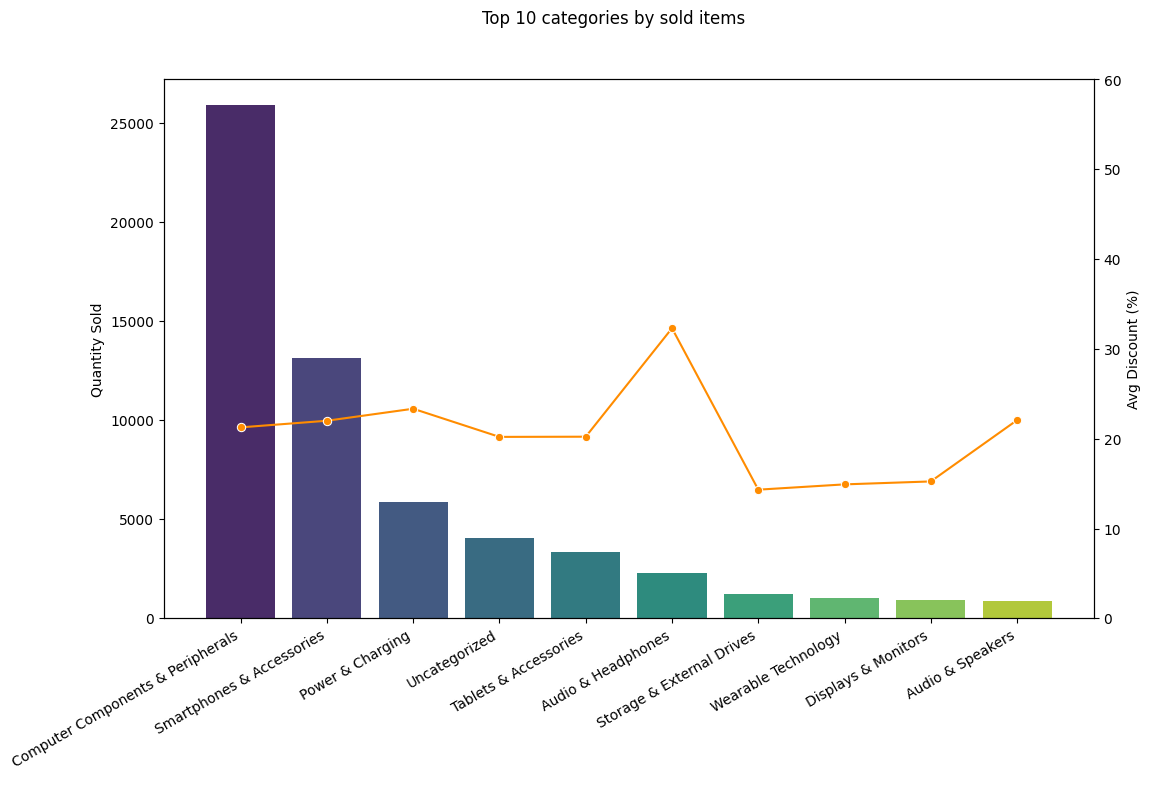

In [22]:
# Creating the figure - top categories by sold items
fig, ax1 = plt.subplots(figsize=(12,7))
sns.barplot(x='category', y='product_quantity', data=top_10_categories_df, ax=ax1, palette='viridis')
ax1.set_ylabel('Quantity Sold')
ax1.set_xlabel(' ')

ax2 = ax1.twinx()
sns.lineplot(x='category', y='discount_percentage', data=top_10_categories_df, ax=ax2, color='darkorange', marker ='o')
ax2.set_ylabel('Avg Discount (%)')
ax2.set_ylim(0,60)
fig.suptitle('Top 10 categories by sold items')
for label in ax1.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
plt.show();

C:\Users\anna_\AppData\Local\Temp\ipykernel_16392\4102314804.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='category', y='total_revenue', data=top_10_cat_revenue, ax=ax1, palette='viridis')


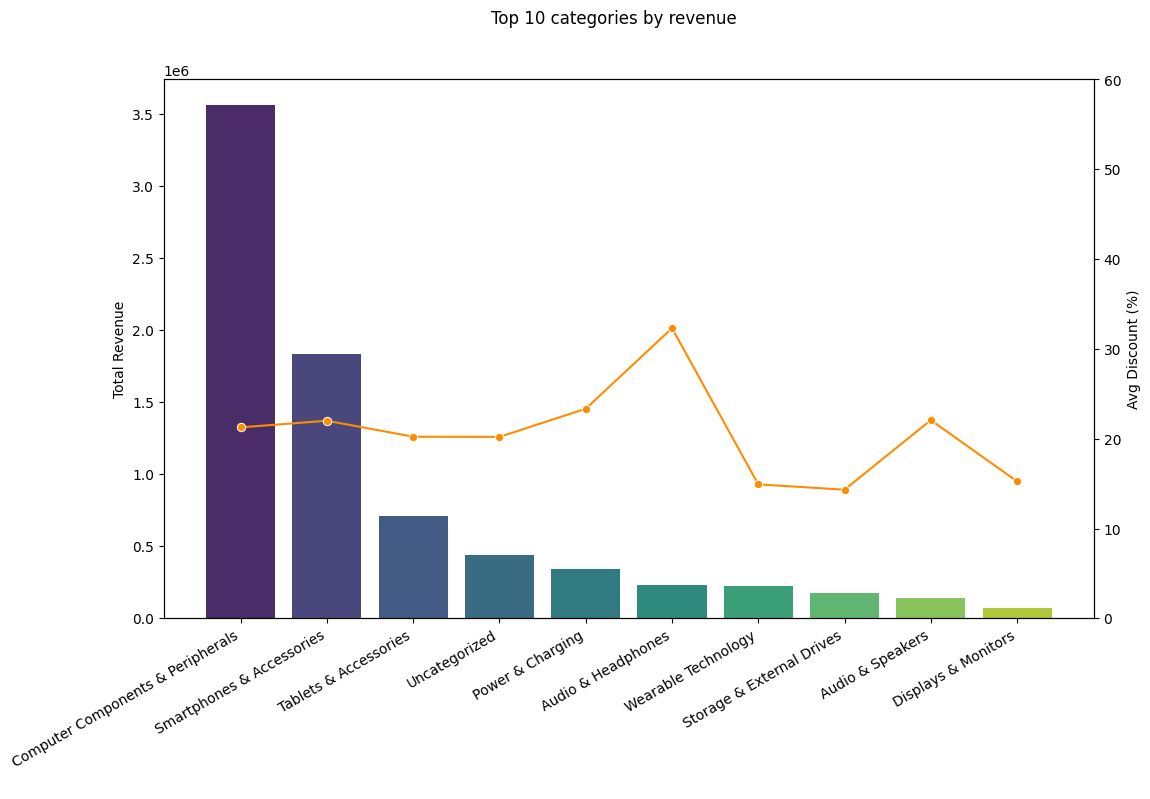

In [25]:
# Creating the figure - top categories by revenue
top_10_cat_revenue = top_10_categories_df.sort_values('total_revenue', ascending=False)

fig, ax1 = plt.subplots(figsize=(12,7))
sns.barplot(x='category', y='total_revenue', data=top_10_cat_revenue, ax=ax1, palette='viridis')
ax1.set_ylabel('Total Revenue')
ax1.set_xlabel(' ')

ax2 = ax1.twinx()
sns.lineplot(x='category', y='discount_percentage', data=top_10_cat_revenue, ax=ax2, color='darkorange', marker ='o')
ax2.set_ylabel('Avg Discount (%)')
ax2.set_ylim(0,60)
fig.suptitle('Top 10 categories by revenue')
for label in ax1.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
plt.show();